[X2 < 76.113]
 [0.0]
 [1.0]
at depth 6  it starts to overfit
accuracy = 80


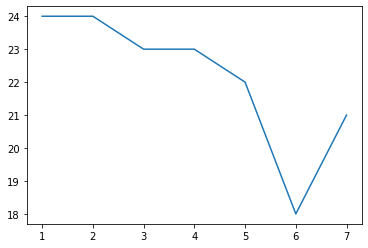

In [ ]:
#reference: https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import random
from random import randrange
from scipy import stats
from math import log2

def splitData(index, value, data):
	left_tree, right_tree = list(), list()
	for row in data:
		if row[index] < value:
			left_tree.append(row)
		else:
			right_tree.append(row)
	return left_tree, right_tree

def informationGain(splits, features):
	n_instances = float(sum([len(split) for split in splits]))
	gain = 0.0
	for split in splits:
		size = float(len(split))
		if size == 0:
			continue
		score = 0.0
		for feature in features:
			prob = [row[-1] for row in split].count(feature) / size
			if prob > 0:
				score += prob * log2(prob)
			else:
				score += 0

		gain += (-score) * (size / n_instances)
	return gain

def fetchSplit(data):
	class_values = list(set(row[-1] for row in data))
	b_index = float('inf') 
	b_value = float('inf')
	b_score = float('inf')
	b_groups = None
	for index in range(len(data[0])-1):
		for row in data:
			groups = splitData(index, row[index], data)
			gain = informationGain(groups, class_values)
			if gain < b_score:
				b_index = index 
				b_value = row[index]
				b_score = gain
				b_groups = groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

def endNode(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

def treeSplit(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])

	if not left or not right:
		node['left'] = node['right'] = endNode(left + right)
		return

	if depth >= max_depth:
		node['left'], node['right'] = endNode(left), endNode(right)
		return

	if len(left) <= min_size:
		node['left'] = endNode(left)
	else:
		node['left'] = fetchSplit(left)
		treeSplit(node['left'], max_depth, min_size, depth+1)

	if len(right) <= min_size:
		node['right'] = endNode(right)
	else:
		node['right'] = fetchSplit(right)
		treeSplit(node['right'], max_depth, min_size, depth+1)

def buildTree(train, max_depth, min_size):
	root = fetchSplit(train)
	treeSplit(root, max_depth, min_size, 1)
	return root

def printTree(node, tree_depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((tree_depth*' ', (node['index']+1), node['value'])))
		printTree(node['left'], tree_depth+1)
		printTree(node['right'], tree_depth+1)
	else:
		print('%s[%s]' % ((tree_depth*' ', node)))

def extractCsv(file, train = 1):
	if file:
		dataset = pd.read_csv(file)
		if train:
			dataset['Gender'] = dataset['Gender'].apply(lambda x: 1 if x == 'M' else 0)
		dataset = dataset.to_numpy()
	return dataset

def predict(node, record):
	if record[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], record)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], record)
		else:
			return node['right']

def selectOption(option):
	if option == 'leaveoneout':
		datasetLeaveOneOut = extractCsv('leaveoneout.csv')
		datasetTrain = datasetLeaveOneOut[:90]
		datasetTest = datasetLeaveOneOut[90:]
	else:
		datasetTrain = extractCsv('Train.csv', 1)
		datasetTest = extractCsv('Test.csv', 0)
	return datasetTrain, datasetTest

def makePredictions(test, sampletree, option = True):
	count = 0
	predictions = list()
	for row in test:
		prediction = predict(sampletree, row)
		predictions.append(prediction)
		if prediction == row[-1]:
			count += 1
	if option:
		return count
	return predictions

def accuracy(predictions, size):
	print('accuracy = %d' % ((predictions/len(size))*100))

option = 'leaveoneout'
#option = 'trainAssignment1'
train, test = selectOption(option)
bestTree = 0
worseTree = float('inf')
bestdepth = 0
worstdepth = 0
prediction_count_list = list()
for i in range(1, 8):
	tree = buildTree(train, i, 1)
	goodPredictions = makePredictions(test, tree)
	prediction_count_list.append(goodPredictions)
	if(goodPredictions > bestTree):
		bestTree = goodPredictions
		bestdepth = i
	if(goodPredictions < worseTree):
		worseTree = goodPredictions
		worstdepth = i

tree = buildTree(train, bestdepth, 1)
printTree(tree)
goodPredictions = makePredictions(test, tree)
plt.plot( list(range(1,8)), prediction_count_list, label='training')
print("at depth %d  it starts to overfit" % (worstdepth))
accuracy(goodPredictions, test)

In [ ]:
def subsample(dataset, w, option = 'bagging'):
  if option == 'bagging':
    indexes = np.random.randint(0, high=(len(dataset)), size=len(dataset), dtype=int)
    sample = dataset[indexes, :]
  else:
    indexes = np.random.choice(np.arange(len(dataset)), size=len(dataset), p=w)
    sample = dataset[indexes, :]
  return sample
 
def mode(numbers):
  return stats.mode(numbers)

classifiersCount = 10
decisiontreePreds = list()
w = np.ones(len(train))/len(train)
for i in range(classifiersCount):
  sample = subsample(train, w, 'bagging')
  sampletree = buildTree(sample, bestdepth, 1)
  preds = makePredictions(test, sampletree, False)
  decisiontreePreds.append(preds)
modeResult = mode(decisiontreePreds)
count = 0
for i in range(len(test)):
  if test[i][-1] == modeResult[0][0][i]:
    count += 1
accuracy(count, test)

accuracy = 86


In [ ]:
classifiersCount = 10
decisiontreePreds = list()
say = np.ones(classifiersCount)
w = np.ones(len(train))/len(train)
treeList = []
for i in range(classifiersCount):
  sample = subsample(train, w, 'boosting')
  sampletree = buildTree(sample, bestdepth, 1)
  treeList.append(sampletree)
  preds = makePredictions(train, sampletree, False)  
  predList = [-1 if i == 0 else i for i in preds]
  e = np.sum(predList != train[-1]) / len(train[-1])
  e = np.clip(e, 1e-10, 1-1e-10)
  say[i] = 0.5 * np.log((1-e)/e)
  testResults = [i[-1] for i in train]
  testResults = np.array(testResults)
  predList = np.array(predList)
  w *= np.exp(-say[i] * testResults * predList)
  w /= sum(w)
predictions = list()
count = 0
for i in range(len(treeList)):
  preds = makePredictions(test, treeList[i], False)
  predictions.append(preds)
modeResult = mode(predictions)
for i in range(len(test)):
  if test[i][-1] == modeResult[0][0][i]:
    count += 1
accuracy(count, test)

accuracy = 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
